# Gradient Boosting

1) Инициализация $predictions$ константной статистикой (AVG)
2) Расчёт $residuals$ ( $-\nabla\mathcal L(y, predictions)$ )
3) Обучение **Weak Learner**(*DecisionTree*) на $X$ и $residuals$\
3.5) Обученный ученик сохраняется в ансамбль
5) Прогноз **Weak Learner** на $X$ умноженный на *learning_rate* прибавляется к $predictions$
6) Шаги 2-4 повторяются $n$ итераций (*n_estimators*)

In [9]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

In [161]:
class GradientBoosting:
    def __init__(self, n_estimators=100, max_depth=3, min_samples_leaf=1, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.trees = []
        self.residuals = []
        self.learning_rate = learning_rate
        self.first_leaf = None
        self.train_score = []
        
    def fit(self, X, y):
        # 1. Инициализация Predictions средним арифметическим
        self.first_leaf = y.mean()
        predictions = np.ones(len(y)) * self.first_leaf

        # 5. Цикл обучения
        for i in range(self.n_estimators):
            # 2. Антиградиент MSE
            residuals = y - predictions
            self.residuals.append(residuals)

            # 3. Обучение Tree на X и Остатках(Антиградиент)
            tree = DecisionTreeRegressor(max_depth = self.max_depth, min_samples_leaf = self.min_samples_leaf)
            tree.fit(X, residuals)
            # 3.5 Сохранение дерева в ансамбль
            self.trees.append(tree)

            # 4. Увеличение predictions на прогноз
            predictions += self.learning_rate * tree.predict(X)
            
    def predict(self, X):           
        predictions = np.ones(X.shape[0]) * self.first_leaf
        
        for i in range(self.n_estimators):
            predictions += self.learning_rate * self.trees[i].predict(X)
            
        return predictions

In [10]:
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

X, y = make_regression(n_samples=2000, n_features=5, n_informative=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [163]:
GB = GradientBoosting(n_estimators=100, min_samples_leaf=10, max_depth=3, learning_rate=0.1)
GB.fit(X_train, y_train)

In [164]:
y_pred = GB.predict(X_test)

In [165]:
display(r2_score(y_test, y_pred), 
        root_mean_squared_error(y_test, y_pred))

0.9931373404624239

11.100506151801872

In [166]:
skGB = GradientBoostingRegressor(n_estimators=100, min_samples_leaf=10, max_depth=3, learning_rate=0.1)
skGB.fit(X_train, y_train)
y_pred = skGB.predict(X_test)

In [167]:
display(r2_score(y_test, y_pred), 
        root_mean_squared_error(y_test, y_pred))

0.9931373404624239

11.100506151801879

# XGBoost

Полная модель бустингового ансамбля:
$$
F(x) = f_0(x)+\sum_{i=1}^T\eta f_t(x)
$$
$f_0(x)$ - Начальное приближение, инициализация начальных константой ( Среднее арифметическое )\
$T$ - Число деревьев в ансамбле ( `n_estimators` )\
$f_t(x)$ - Предсказание дерева на $t$-итерации\
$\eta$ - Шаг обучения ( `learning_rate` )

---

Построить такую модель $F(x)$, которая минимизируеи эмпирический риск, то есть ошибка по результатам ансамбля будет минимально возможная в данной ситуации.
$$
F^*(x) = \arg\min_{F} \sum_{i=1}^n\mathcal L(y_i, F(x_i))    \hspace{1cm}  \mathcal L(y_i, \hat{y_i})\rightarrow min
$$
$F^*(x)$ - Оптимальная модель\
$\arg\min_{F}$ - Выбор из всех функций $F$ такую, которая выдает минимальное суммарное значение **ошибки** по всем объектам\
$F(x_i)$=$\hat{y_i}$ - Предсказание модели \
$\mathcal L(y_i, F(x_i)$ - Функция потерь измеряющая ошибку на $i$-ом объекте



---
**Полная функция потерь**, минимизируемая на каждом шаге $t$ состоит из двух слогаемых - самой функции потерь и регуляризационной накопительной
$$
\mathcal L(y_i, \hat{y_i})= \sum_{i=1}^nL(y_i, \hat{y_i}) + \sum_{k=1}^t\Omega f_k(x)
$$
$$
\Omega (f_k(x)) = \gamma NumLeaves + \frac{1}{2} \lambda \sum^T_{j=1}{w_j^2}
$$

$\mathcal L(y_i, \hat{y_i})$ -  Полная функция функция потерь\
$\sum_{i=1}^nL(y_i, \hat{y_i})$ - Накопительная ошибка (Суммарная ошибка по всем объектам)\
$\sum_{k=1}^t\Omega f_k$ - Накопительный штраф (Суммарный штраф по всем деревьям)

$n$ - количество объектов( строк данных )\
$t$ - количество деревьев( `n_estimators` )\
$L(y_i, \hat{y_i})$ - Выбранная функция потерь\
$f_k$ - $k$-ое дерево в ансамбле ( $k = 1,2,3,...,t$ )\
$\Omega f_k(x)$ - Регуляризационный штраф за структуру $k$-го дерева\
$NumLeaves$ - Количество листьев в дереве $f_k$\
$\lambda$ - Коэффициент L2-регуляризации весов ( `reg_lambda` ) \
$\gamma$ - Коэффициент регуляризации для числа листьев. Штраф за каждый новый лист. (`gamma`)\
$w_j$ - Вес $j$-го листа.

------
На каждом шаге $t$ для каждого объекта $i$ функция потерь $\mathcal L(y_i, F(x_i)$ разлагается в Ряд Тейлора до второго порядка в окрестностях текущего предсказания.
$$
\mathcal L(y_i, F(x_i) \approx \mathcal L(y_i, F_{t-1}(x_i))+g_if_t(x_i) + \frac{1}{2}h_if_t(x_i)^2 + \Omega (f_t)
$$
$$
\mathcal L^{(t)} \approx \sum_{i=1}^n \Big[ g_if_t(x_i)+\frac{1}{2}h_if_t(x_i)^2\Big] + \Omega (f_t)
$$
$f_t(x_i)$ - Новое предсказание дерева $t$-итерации для объекта $x_i$\
$g_j$ - Градиент значений $j$-листа (Производная по предсказанию)\
$h_j$ - Гессиан значений $j$-листа (Производная второго порядка по предсказанию)
$$
g_i = \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \hspace{2cm} h_i\frac{\partial^2 L(y_i, F(x_i))}{\partial F(x_i)^2} 
$$
Минимизация функции потерь осуществляется с использованием этих разложений. Ищется такой шаг $f_t(x)$  который минимизирует ошибку. Для этого учитывается как градиент, так и гессиан, которые нам показывают, как наилучшим образом обновить предсказание.

Оптимизации методом градиентного спуска недостаточно для минимизации ошибки. Вместо этого, используется разложение в ряд Тейлора, чтобы аппроксимировать, как будет изменяться ошибка, если мы добавим предсказания от нового дерева. Таким образом, обучение дерева сводится к минимизации разложения по текущим градиентам и гессианам. 


Алгоритм построения дерево вычисляет оценку качества(Information Gain) для каждого разбиения:
$$
IG = \frac{1}{2} \Big[\frac{G^2_{L}}{H_{L}+\lambda}+\frac{G^2_{R}}{H_{R}+\lambda} - \frac{(G_L+G_R)^2}{H_L + H_R + \lambda}\Big] - \gamma
$$

$$
G_{L/R} = \sum_{i \in l/r} g_i \hspace{2cm} H_{L/R} = \sum_{i \in l/r} h_i \hspace{2cm}
$$
$G_L$, $G_R$ - Суммы **градиентов** в левом и правом подмножестве после разбиения\
$H_L$, $G_R$ - Суммы **гессианов** в левом и правом подмножестве после разбиения





-------
$w_j$ -Прогноз выдоваемый $j$-ым листом. Решение задачи оптимизации через производные.\
Агрегированный прогноз по всем объектам в этом листе, но скорректированный так, чтобы минимизировать функцию потерь через производные первого и второго порядка. 
$$
w_j = - \frac{G_j}{H_j+\lambda}
$$


$$
w_j = - \frac{\sum_{i \in I_j} g_i}{\sum_{i \in I_j} h_i + \lambda}
$$

$I_j$ - Множество объектов, попавших в лист $j$

# Params

In [15]:
gbm = xgb.XGBRegressor(
    booster='gbtree',
    n_jobs=-1
)

In [19]:
params={
    'n_estimators': [100, 1000], # Количество учеников
    'learning_rate': [0.01, 0.3], # Шаг обучения ( eta )
    'max_depth': [3, 10], # Глубина дерева ( default=6 )
    'reg_lambda': [0, 1], # Коэффициент L2-регуляризации ( >1 )
    'reg_alpha': [0, 1], # Коэффициент L1-регуляризации ( >1 )
    'gamma': [0, 10], # Минимальное улучшение потерь для сплита
    'min_child_weight': [1, 10], # Минимальное значение для суммы весов в узле потомке
    'subsample' : [0.5, 1], # 	Доля случайных объектов для каждого дерева
    'colsample_bytree': [0.5, 1] # Доля случайных признаков для каждого дерева
    #'scale_pos_weight': []  в случае несбалансированных классов
}

In [20]:
import xgboost as xgb
gbm = xgb.XGBRegressor(n_jobs=-1, # ядра процессора
                       booster='gbtree', # gbtree-default | gblinear, dart - хуже
                       eval_metric='rmse')

In [21]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=2000, n_features=5, n_informative=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.9)

In [26]:
gbm.fit(X_train, y_train, 
        verbose=5, # Шаг вывода логов
        eval_set=[(X_val, y_val)] # Валидационная
       )

[0]	validation_0-rmse:67.54021
[5]	validation_0-rmse:20.67915
[10]	validation_0-rmse:13.42403
[15]	validation_0-rmse:12.34834
[20]	validation_0-rmse:11.82488
[25]	validation_0-rmse:11.58576
[30]	validation_0-rmse:11.50328
[35]	validation_0-rmse:11.51720
[40]	validation_0-rmse:11.52468
[45]	validation_0-rmse:11.52985
[50]	validation_0-rmse:11.40133
[55]	validation_0-rmse:11.42868
[60]	validation_0-rmse:11.47443
[65]	validation_0-rmse:11.46192
[70]	validation_0-rmse:11.50107
[75]	validation_0-rmse:11.46473
[80]	validation_0-rmse:11.44528
[85]	validation_0-rmse:11.43493
[90]	validation_0-rmse:11.43846
[95]	validation_0-rmse:11.46088
[99]	validation_0-rmse:11.46686


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [27]:
y_pred = gbm.predict(X_test)

In [28]:
from sklearn.metrics import r2_score, root_mean_squared_error
display(r2_score(y_test, y_pred),
       root_mean_squared_error(y_test, y_pred))

0.9820253813090923

12.419560888233864

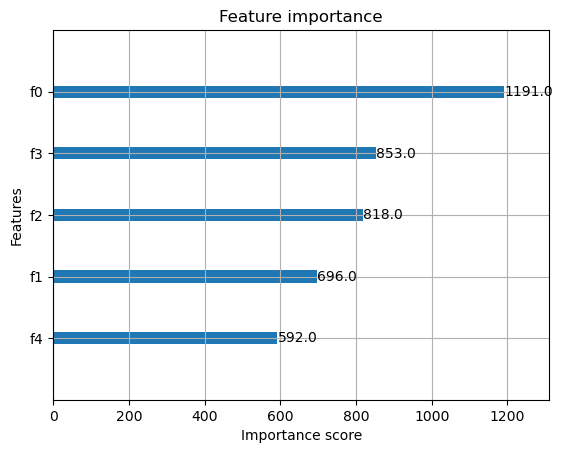

In [29]:
xgb.plot_importance(gbm);

In [30]:
booster = gbm.get_booster()
fscore = booster.get_fscore()
fscore

{'f0': 1191.0, 'f1': 696.0, 'f2': 818.0, 'f3': 853.0, 'f4': 592.0}